In [33]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl
import matplotlib.ticker as ticker


In [34]:
USER='wilderlavington' 
PROJECT='FunctionalOptimizationFinal'
SUMMARY_FILE='FuncOptSVMlib.csv'  
try:
    os.makedirs("plots/aistats/")
except FileExistsError:
    print("File already exists")

File already exists


In [35]:
%run plotting_utils.py

In [32]:
download_wandb_summary(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

  4%|█▋                                      | 117/2755 [00:21<08:02,  5.47it/s]


KeyboardInterrupt: 

In [ ]:
download_wandb_records(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [36]:
def generate_sgd_figure(loss, schedule, wandb_records, fig_name, 
                        dataset_names= ['mushrooms', 'rcv1'],
                        x ='optim_steps', y='avg_loss', include_leg=True, 
                        sso_algo = 'SGD_FMDOpt'):
    
    # base info    
    batch_sizes = [25, 125, 625]
    m = [1, 10, 20] 
    
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 3))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77', 'Adam': '#88CCEE' }
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-10': '#AA4499', 'SSO-20': '#882255' , 'SSO-SLS': '#332288'})
    algorithms = ['SGD', 'Adam', 'SLS'] + ['SSO-'+str(m_) for m_ in m] +['SSO-SLS']
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SLS', 
                                         linestyle='dashed', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

        # SGD
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SGD', 
                                         linestyle='dashed', color=colormap['SGD'])
        else:
            print('missing SGD  ', dataset_name, 'full-batch')
        
        # Adam
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
            'eta_schedule': 'constant', 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adam', 
                                         linestyle='dashed', color=colormap['Adam'])
        else:
            print('missing Adam  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': sso_algo, 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch') 
        axs[row][-1].grid()     
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log") 
        
        # SLS-FMDOpt
        proc_df = format_dataframe(wandb_records, 
            id_subfields={'fullbatch': 1,   
                'use_optimal_stepsize': 1, #'_step': 499.0,
                'loss': loss, 'algo': 'SLS_FMDOpt', 'm': 20,
                'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                 avg_subfields=['seed'], max_subfields=['c'],
            x_col=x, y_col=y)
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], \
                                    label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-SLS'])
        else:
            print('missing FMDopt  ', m_, dataset_name, batch_size)
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0 
            
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                             linestyle='dashed', color=colormap['SLS'])
            else:
                print('missing SLS  ', dataset_name, batch_size)
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SGD', 
                                             linestyle='dashed', color=colormap['SGD'])
            else:
                print('missing SGD  ', dataset_name, batch_size)
            
            # Adam
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,  
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
                'eta_schedule': 'constant', 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adam', 
                                             linestyle='dashed', color=colormap['Adam'])
            else:
                print('missing Adam  ', dataset_name, batch_size)
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, #'_step': 499.0,
                        'loss': loss, 'algo': sso_algo, 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size)
                
            # SLS-FMDOpt
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'batch_size': batch_size,  
                    'use_optimal_stepsize': 1, #'_step': 499.0,
                    'loss': loss, 'algo': 'SLS_FMDOpt', 'm': 20,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-SLS'])
            else:
                print('missing FMDopt  ', m_, dataset_name, batch_size) 
            
            axs[row][col].grid()     
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            if not include_leg:
                axs[0][col].set_title('batch-size: '+str(batch_size), fontsize=16)
                axs[0][-1].set_title('full-batch', fontsize=16)
            axs[row][-1].set_ylabel(dataset_name, fontsize=16)
            axs[row][-1].yaxis.set_label_position("right") 
        
        axs[row][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
        axs[row][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
        axs[row][col].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
    # remaining format stuff  
    if include_leg:
        handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
        leg = fig.legend(handles=handles,
               loc="lower center",   # Position of legend
               borderaxespad=1.65,    # Small spacing around legend box
               # title="Algorithms",  # Title for the legend
               fontsize=18,
               ncol=8, 
               bbox_to_anchor=(0.525, -0.3),
               )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-plot-sgd_sso-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

In [37]:
#  wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)

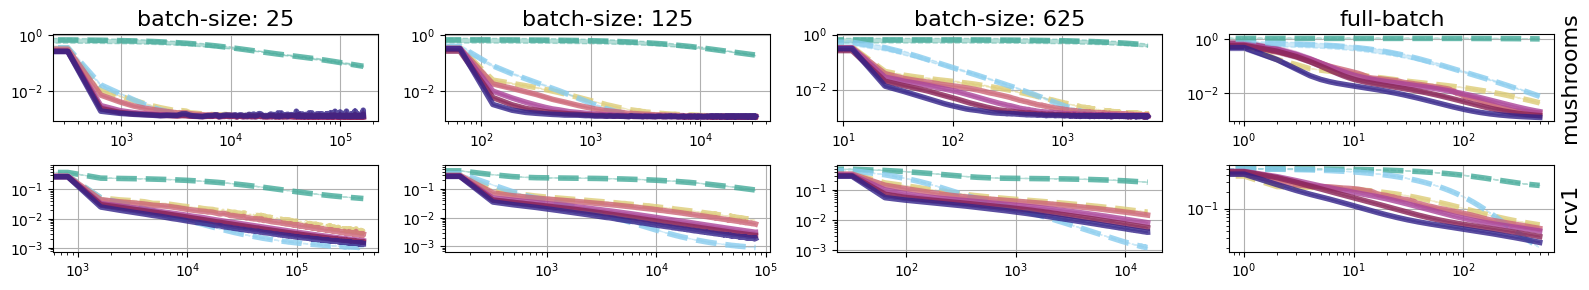

In [38]:
# loss comparison
generate_sgd_figure('MSELoss', 'constant', 
                    wandb_records, fig_name=SUMMARY_FILE+'_a', x ='optim_steps', 
                    y='avg_loss', include_leg=False, sso_algo = 'SGD_FMDOpt')
# grad-norm comparison
# generate_sgd_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# generate_sgd_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sgd_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

In [42]:
generate_sgd_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name=SUMMARY_FILE+'_a', x ='optim_steps', y='avg_loss', include_leg=False)

KeyboardInterrupt: 

In [ ]:
generate_sgd_figure('BCEWithLogitsLoss', 'constant', 
                    wandb_records, fig_name=SUMMARY_FILE+'_a', x ='optim_steps', 
                    y='avg_loss', include_leg=True, sso_algo = 'SGD_FMDOpt')

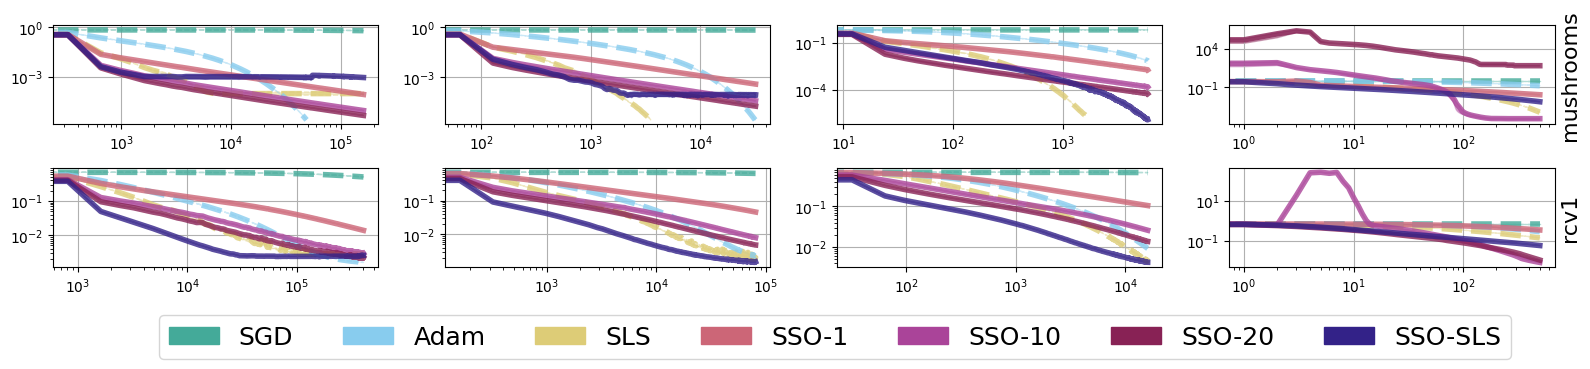

In [43]:
generate_sgd_figure('BCEWithLogitsLoss', 'constant', 
                    wandb_records, fig_name=SUMMARY_FILE+'_a', x ='optim_steps', 
                    y='avg_loss', include_leg=True, sso_algo = 'Online_Newton_FMDOpt')

In [ ]:
# loss comparison
# generate_sgd_figure('MSELoss', 'stochastic', wandb_records, fig_name=SUMMARY_FILE+'b', x ='optim_steps', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, fig_name=SUMMARY_FILE+'b', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_sgd_figure('MSELoss', 'stochastic', wandb_records, fig_name='b', x ='optim_steps', y='grad_norm')
# generate_sgd_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, fig_name='b', x ='optim_steps', y='grad_norm')
# time-elapsed comparison
# generate_sgd_figure('MSELoss', 'stochastic', wandb_records, fig_name='b', x ='time_elapsed', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, fig_name='b', x ='time_elapsed', y='avg_loss')

In [286]:
# loss comparison
# generate_sgd_figure('MSELoss', 'exponential', wandb_records, fig_name=SUMMARY_FILE+'c', x ='optim_steps', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'exponential', wandb_records, fig_name=SUMMARY_FILE+'c', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_sgd_figure('MSELoss', 'exponential', wandb_records, fig_name='c', x ='optim_steps', y='grad_norm')
# generate_sgd_figure('BCEWithLogitsLoss', 'exponential', wandb_records, fig_name='c', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sgd_figure('MSELoss', 'exponential', wandb_records, fig_name='c', x ='time_elapsed', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'exponential', wandb_records, fig_name='c', x ='time_elapsed', y='avg_loss')

In [287]:
  wandb_records = pd.read_csv('/home/wlavington/Desktop/FunctionalStochasticOptimization/plotting/logs/wandb_data/__full__aistats_all.csv', header=0, squeeze=True)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,45,48,52,56,62,66,68,70,75,76,89,90,107,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [288]:
 def generate_runtime_figure(loss, schedule, wandb_records, fig_name):
    
    # base info   
    x ='optim_steps'
    y ='time_elapsed'
    
       # base info   
    dataset_names = ['rcv1',]
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20] 
#     wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 2))
    axs = [axs]
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77', 'Adam': '#88CCEE'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-100': '#332288',  'SSO-20': '#332288'})
    algorithms = ['SGD', 'Adam', 'SLS'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically  
        run_times = []
        run_times_min = []
        run_times_max = []
        algos = []

        # SGD
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            run_times.append(proc_df[y].values.max())
            run_times_max.append(proc_df[y+'75'].values.max())
            run_times_min.append(proc_df[y+'25'].values.max())
            algos.append('SGD')
        else:
            run_times.append(0.)
            run_times_max.append(0.)
            run_times_min.append(0.)
            algos.append('SGD')
            print('missing SLS  ', dataset_name, 'full-batch')
        
        # Adam
#         proc_df = format_dataframe(wandb_records,
#             id_subfields={'fullbatch': 1, #'_step': 499.0,  
#             'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
#             'eta_schedule': 'constant', 'dataset_name': dataset_name},
#             x_col=x , y_col=y) 
#         if proc_df is not None:
#             run_times.append(proc_df[y].values.max())
#             run_times_max.append(proc_df[y+'75'].values.max())
#             run_times_min.append(proc_df[y+'25'].values.max())
#             algos.append('Adam')
#         else:
#             run_times.append(0.)
#             run_times_max.append(0.)
#             run_times_min.append(0.)
#             algos.append('Adam')
#             print('missing Adam  ', dataset_name, 'full-batch')
        
        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y)  
        if proc_df is not None:
            run_times.append(proc_df[y].values.max())
            run_times_max.append(proc_df[y+'75'].values.max())
            run_times_min.append(proc_df[y+'25'].values.max())
            algos.append('SLS')
        else:
            run_times.append(0.)
            run_times_max.append(0.)
            run_times_min.append(0.)
            algos.append('SLS')
            print('missing SLS  ', dataset_name, 'full-batch')

        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                run_times.append(proc_df[y].values.max())
                run_times_max.append(proc_df[y+'75'].values.max())
                run_times_min.append(proc_df[y+'25'].values.max())
                algos.append('SSO-'+str(m_))
            else:
                run_times.append(0.)
                run_times_max.append(0.)
                run_times_min.append(0.)
                algos.append('SSO-'+str(m_))
        
        axs[row][-1].barh([_ for _ in range(len(algos))], run_times, 
                                align='center', edgecolor = "black",
                                color=[colormap[algo] for algo in algos],
#                                   xerr=[run_times_min, run_times_max]
                         )
        axs[row][-1].set_yticks([_ for _ in range(len(algos))], labels=algos)
        axs[row][-1].grid()      
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            run_times = []
            run_times_min = []
            run_times_max = []
            algos = []
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                run_times.append(proc_df[y].values.max())
                run_times_max.append(proc_df[y+'75'].values.max())
                run_times_min.append(proc_df[y+'25'].values.max())
                algos.append('SGD')
            else:
                run_times.append(0.)
                run_times_max.append(0.)
                run_times_min.append(0.)
                algos.append('SGD')
                print('missing SGD  ', dataset_name, 'full-batch')
            
            # Adam
#             proc_df = format_dataframe(wandb_records,
#                 id_subfields={'batch_size': batch_size, #'_step': 499.0,  
#                 'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
#                 'eta_schedule': 'constant', 'dataset_name': dataset_name},
#                 x_col=x , y_col=y) 
#             if proc_df is not None:
#                 run_times.append(proc_df[y].values.max())
#                 run_times_max.append(proc_df[y+'75'].values.max())
#                 run_times_min.append(proc_df[y+'25'].values.max())
#                 algos.append('Adam')
#             else:
#                 run_times.append(0.)
#                 run_times_max.append(0.)
#                 run_times_min.append(0.)
#                 algos.append('Adam')
#                 print('missing Adam  ', dataset_name, 'full-batch')
            
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                run_times.append(proc_df[y].values.max())
                run_times_max.append(proc_df[y+'75'].values.max())
                run_times_min.append(proc_df[y+'25'].values.max())
                algos.append('SLS')
            else:
                run_times.append(0.)
                run_times_max.append(0.)
                run_times_min.append(0.)
                algos.append('SLS')
                print('missing SLS  ', dataset_name, 'full-batch')
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, #'_step': 499.0,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    run_times.append(proc_df[y].values.max())
                    run_times_max.append(proc_df[y+'75'].values.max())
                    run_times_min.append(proc_df[y+'25'].values.max())
                    algos.append('SSO-'+str(m_))
                else:
                    run_times.append(0.)
                    run_times_max.append(0.)
                    run_times_min.append(0.)
                    algos.append('SSO-'+str(m_))
            
            axs[row][col].barh([_ for _ in range(len(algos))], run_times, 
                                align='center', edgecolor = "black",
                                color=[colormap[algo] for algo in algos],
#                                 xerr=[run_times_min, run_times_max]
                              )
            axs[row][col].set_yticks([_ for _ in range(len(algos))], labels=algos)
#             axs[row][col].set_title('batch-size: '+str(batch_size), fontsize=22)
            axs[row][col].grid()  
        
        # 
        
#         axs[0][-1].set_title('full-batch', fontsize=22)
#         axs[row][-1].set_ylabel(dataset_name, fontsize=22)
        axs[row][-1].yaxis.set_label_position("right") 
    
#     plt.subplots_adjust(hspace=1.5)
#     plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-plot-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

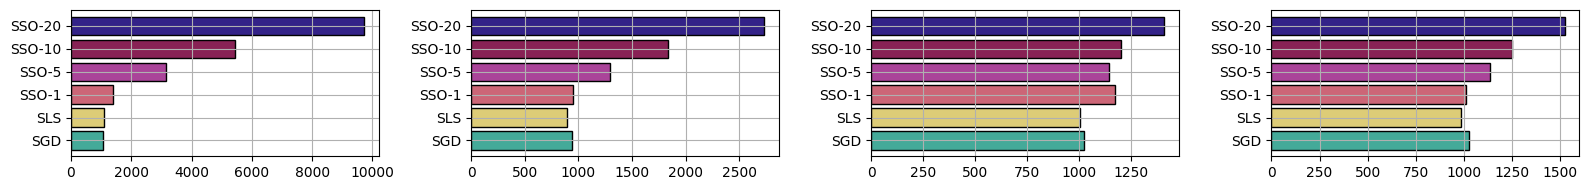

In [289]:
 generate_runtime_figure('MSELoss', 'constant', wandb_records, fig_name='run-times')

In [7]:
 def generate_det_figure(wandb_records, fig_name, x ='optim_steps', y='avg_loss'):
    
    # base info   
    dataset_name = 'mushrooms' # , 'ijcnn', 'rcv1' 
    m = [1, 5, 10, 20]
    sso_variants = ['SLS_FMDOpt', 'Ada_FMDOpt'] #'Online_Newton_FMDOpt' 'SGD_FMDOpt',
    loss = 'MSELoss'
    schedule = 'constant'
#     wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs = [axs]
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77', 'Adagrad': '#88CCEE'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255', 'SSO-20': '#332288'})
    algorithms = ['Adagrad', 'SLS'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    algo_mask = {'SGD_FMDOpt': 'SSO-SGD', 'SLS_FMDOpt': 'SSO-SLS', 
                 'Ada_FMDOpt': 'SSO-Adagrad', 
                 'Online_Newton_FMDOpt': 'SSO-Newton'}
    # now add in the lines to each of the plots 
    for col, sso_variant in enumerate(sso_variants):
        
        row = min(int(np.floor(col / 2)), 1)
        col = col % 2
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y, k=3) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                         linestyle='dashed', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

#         # SGD
#         proc_df = format_dataframe(wandb_records,
#             id_subfields={'fullbatch': 1,  
#             'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
#             'eta_schedule': schedule, 'dataset_name': dataset_name},
#             x_col=x , y_col=y, k=3)
#         if proc_df is not None: 
#             x_max = max(proc_df[x].values.max(), x_max)
#             axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SGD', 
#                                          linestyle='dashed', color=colormap['SGD'])
#         else:
#             print('missing SGD  ', dataset_name, 'full-batch')
        
        # Adagrad
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
            'eta_schedule': 'constant', 'dataset_name': dataset_name},
            x_col=x , y_col=y, k=2) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adagrad', 
                                         linestyle='dashed', color=colormap['Adagrad'])
        else:
            print('missing Adagrad  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': sso_variant, 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y, k=3)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing '+sso_variant+'FMDopt  ', m_, dataset_name, 'full-batch') 
        axs[row][col].grid()     
        axs[row][col].set_yscale("log")
        axs[row][col].set_xscale("log")  
#         axs[row][col]..set_ylim([1e-6, ymax])
#         axs[0][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#         axs[0][col].yaxis.set_major_locator(plt.MaxNLocator(4)) 
#         axs[0][col].set_title('batch-size: '+str(batch_size), fontsize=22)
        axs[row][col].set_title(algo_mask[sso_variant], fontsize=18)
        axs[row][col].set_xticks([10**0, 10**1, 10**2], major=True)
#         axs[0][col].set_ylabel(dataset_name, fontsize=22)
#         axs[0][col].yaxis.set_label_position("right") 
#         axs[0][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
#         axs[0][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
#         axs[0][col].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
#     remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.25,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=12,
           ncol=8, 
           bbox_to_anchor=(0.525, -0.175),
           )
    
    plt.subplots_adjust(hspace=1.25)
    plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-plot-algo-compare-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,44,47,50,55,58,60,62,72,73,104,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


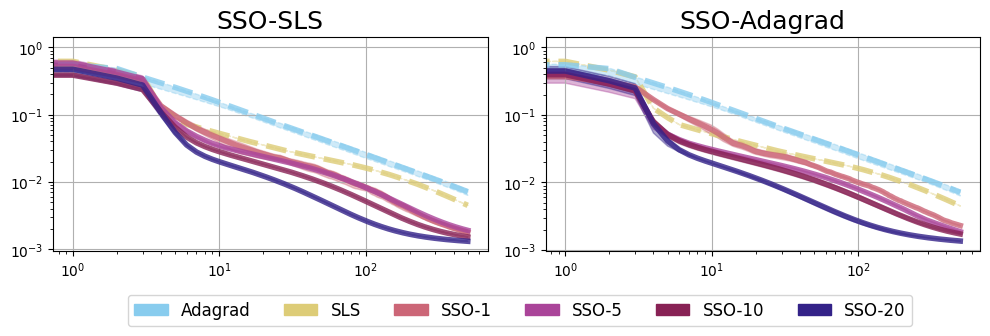

In [8]:
wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)
generate_det_figure(wandb_records, fig_name='other-optim-det', x ='optim_steps', y='avg_loss')

In [76]:
 def generate_stoch_figure(wandb_records, fig_name, x ='optim_steps', y='avg_loss'):
    
    # base info   
    dataset_name = 'ijcnn' # , 'ijcnn', 'rcv1' 
    m = [1, 5, 10, 20]
    sso_variants = ['SLS_FMDOpt', 'Ada_FMDOpt'] #'Online_Newton_FMDOpt' 'SGD_FMDOpt',
    loss = 'MSELoss'
    schedule = 'constant'
#     wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs = [axs]
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77', 'Adagrad': '#88CCEE'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255', 'SSO-20': '#332288'})
    algorithms = ['Adagrad', 'SLS'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    algo_mask = {'SGD_FMDOpt': 'SSO-SGD', 'SLS_FMDOpt': 'SSO-SLS', 
                 'Ada_FMDOpt': 'SSO-Adagrad', 
                 'Online_Newton_FMDOpt': 'SSO-Newton'}
    # now add in the lines to each of the plots 
    for col, sso_variant in enumerate(sso_variants):
        
        row = min(int(np.floor(col / 2)), 1)
        col = col % 2
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 0, 'batch_size': 5,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y, k=3) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                         linestyle='dashed', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

        # Adagrad
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 0, 'batch_size': 5,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
            'eta_schedule': 'constant', 'dataset_name': dataset_name},
            x_col=x , y_col=y, k=2) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adagrad', 
                                         linestyle='dashed', color=colormap['Adagrad'])
        else:
            print('missing Adagrad  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 0, 'batch_size': 5,  
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': sso_variant, 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y, k=3)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing '+sso_variant+'FMDopt  ', m_, dataset_name, 'full-batch') 
        
        axs[row][col].grid()     
        axs[row][col].set_yscale("log")
        axs[row][col].set_xscale("log")   
        axs[row][col].set_title(algo_mask[sso_variant], fontsize=18)  
        axs[row][col].set_xticks([10**4, 10**5, 10**6], major=True)
        axs[row][col].set_xlims([10**1, 10**6])
        
#     remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.25,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=12,
           ncol=8, 
           bbox_to_anchor=(0.525, -0.175),
           )
    
#     axs[0][0].set_xticklabels([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])
#     axs[0][1].set_xticklabels([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])
    plt.subplots_adjust(hspace=1.25)
    plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-plot-algo-compare-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

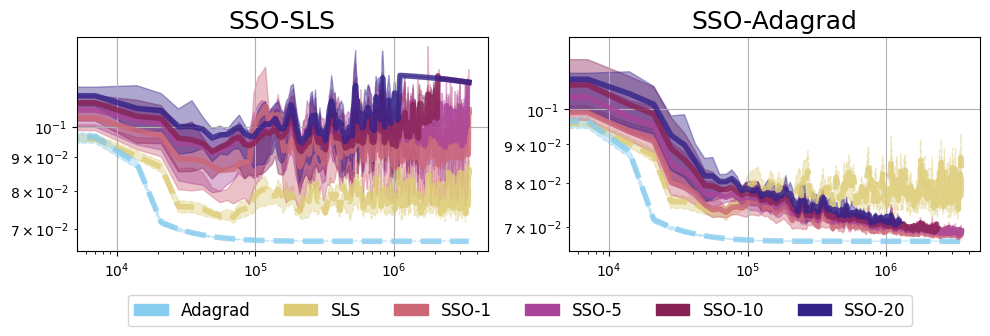

In [77]:
# wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)
generate_stoch_figure(wandb_records, fig_name='other-optim-stoch', x ='optim_steps', y='avg_loss')